In [1]:
import os
os.environ["AMD_SERIALIZE_KERNEL"] = "3" 
os.environ["HSA_OVERRIDE_GFX_VERSION"] = "11.0.0"
os.environ["HIP_VISIBLE_DEVICES"] = "0"

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from tqdm.notebook import tqdm
import math
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # seems to be slower at small nn size
device = torch.device("cpu")

In [3]:
import random
import re

def spaces_gen(num: int) -> str:
    return "".join(' ' for _ in range(num))

# Converted from https://featurecrew.io/tests/maze

class MazeGenerator:
    def __init__(self, maze_size=20):
        self.maze_size = maze_size
        self.maze = []
        self.solution_path = []
        
        # Directions for maze generation and movement
        self.directions = [
            {"dx": 0, "dy": -1, "wall": "top", "opposite": "bottom"},
            {"dx": 1, "dy": 0, "wall": "right", "opposite": "left"},
            {"dx": 0, "dy": 1, "wall": "bottom", "opposite": "top"},
            {"dx": -1, "dy": 0, "wall": "left", "opposite": "right"}
        ]
        
        # Initialize and generate the maze
        self.generate_maze()
        self.solution_path = self.find_solution()
    
    def init_maze(self):
        """Initialize maze grid with all walls intact"""
        self.maze = []
        for y in range(self.maze_size):
            row = []
            for x in range(self.maze_size):
                row.append({
                    "x": x, 
                    "y": y,
                    "walls": {"top": True, "right": True, "bottom": True, "left": True},
                    "visited": False
                })
            self.maze.append(row)
    
    def get_cell(self, x, y):
        """Retrieve cell at (x,y) or None if out of bounds"""
        if x < 0 or y < 0 or x >= self.maze_size or y >= self.maze_size:
            return None
        return self.maze[y][x]
    
    def generate_maze(self):
        """Generate maze using recursive backtracking (depth-first search)"""
        self.init_maze()
        stack = []
        current = self.maze[0][0]
        current["visited"] = True
        
        while True:
            neighbors = []
            for d in self.directions:
                next_cell = self.get_cell(current["x"] + d["dx"], current["y"] + d["dy"])
                if next_cell and not next_cell["visited"]:
                    neighbors.append({"cell": next_cell, "direction": d})
            
            if neighbors:
                rnd = random.choice(neighbors)
                current["walls"][rnd["direction"]["wall"]] = False
                rnd["cell"]["walls"][rnd["direction"]["opposite"]] = False
                stack.append(current)
                current = rnd["cell"]
                current["visited"] = True
            elif stack:
                current = stack.pop()
            else:
                break
        
        # Add extra openings to create loops (multiple valid solutions)
        extra_chance = 0.1
        for y in range(self.maze_size):
            for x in range(self.maze_size):
                for d in self.directions:
                    nx, ny = x + d["dx"], y + d["dy"]
                    neighbor = self.get_cell(nx, ny)
                    if neighbor and self.maze[y][x]["walls"][d["wall"]] and random.random() < extra_chance:
                        self.maze[y][x]["walls"][d["wall"]] = False
                        neighbor["walls"][d["opposite"]] = False
    
    def find_solution(self, startx = 0, starty = 0):
        """Find shortest solution path using breadth-first search"""
        start = self.maze[starty][startx]
        goal = self.maze[self.maze_size - 1][self.maze_size - 1]
        queue = []
        came_from = [[None for _ in range(self.maze_size)] for _ in range(self.maze_size)]
        visited = [[False for _ in range(self.maze_size)] for _ in range(self.maze_size)]
        
        queue.append(start)
        visited[start["y"]][start["x"]] = True
        
        while queue:
            current = queue.pop(0)
            if current == goal:
                break
            
            for d in self.directions:
                if not current["walls"][d["wall"]]:
                    nx, ny = current["x"] + d["dx"], current["y"] + d["dy"]
                    neighbor = self.get_cell(nx, ny)
                    if neighbor and not visited[ny][nx]:
                        visited[ny][nx] = True
                        came_from[ny][nx] = current
                        queue.append(neighbor)
        
        path = []
        current = goal
        while current != start:
            path.append(current)
            current = came_from[current["y"]][current["x"]]
            if not current:
                break
        
        path.append(start)
        path.reverse()
        return path
    
    def get_column_label(self, index):
        """Convert a zero-indexed column number into Excel-style label (A, B, …, AA, etc.)"""
        label = ""
        index += 1
        while index > 0:
            mod = (index - 1) % 26
            label = chr(65 + mod) + label
            index = (index - mod) // 26
        return label

    def generate_maze_text(self):
        """Generate an ASCII representation of the maze with sector indicators"""
        text = spaces_gen(5)
        # Column header
        for x in range(self.maze_size):
            text += spaces_gen(1) + self.get_column_label(x) + spaces_gen(2)
        text += "\n"
        
        # Top border (using first row's top walls)
        text += spaces_gen(4)
        for x in range(self.maze_size):
            text += "+---" if self.maze[0][x]["walls"]["top"] else "+" + spaces_gen(3)
        text += "+\n"
        
        # For each row, print the interior and bottom wall
        for y in range(self.maze_size):
            row_line = str(y+1).rjust(3) + spaces_gen(1)
            for x in range(self.maze_size):
                row_line += "|" + spaces_gen(3) if self.maze[y][x]["walls"]["left"] else spaces_gen(4)
            row_line += "|\n"
            text += row_line
            
            wall_line = spaces_gen(4)
            for x in range(self.maze_size):
                wall_line += "+---" if self.maze[y][x]["walls"]["bottom"] else "+" + spaces_gen(3)
            wall_line += "+\n"
            text += wall_line
        
        return text
    
    def parse_plan(self, input_text):
        """Parse the plan input (expects tokens like A1, B2, etc.)"""
        tokens = re.findall(r'[A-Za-z]+\d+', input_text)
        if not tokens:
            return []
        
        plan = []
        for token in tokens:
            match = re.match(r'^([A-Za-z]+)(\d+)$', token)
            if not match:
                continue
            
            col_str = match.group(1).upper()
            row_str = match.group(2)
            
            col = 0
            for char in col_str:
                col = col * 26 + (ord(char) - 64)
            col -= 1  # convert to 0-indexed
            
            row = int(row_str) - 1
            plan.append({"label": token.upper(), "x": col, "y": row})
        
        return plan
    
    def validate_plan(self, plan):
        """Validate the plan by checking adjacency and wall collisions"""
        validated = []
        errors = []
        
        if not plan:
            errors.append("No valid moves found in the plan.")
            return validated, errors
        
        # Check starting point is A1
        if plan[0]["x"] != 0 or plan[0]["y"] != 0:
            errors.append("Plan must start at A1.")
        
        # Check ending point is bottom-right
        if plan[-1]["x"] != self.maze_size - 1 or plan[-1]["y"] != self.maze_size - 1:
            errors.append(f"Plan must end at {self.get_column_label(self.maze_size - 1)}{self.maze_size}.")
        
        # Validate each move step
        for i, pos in enumerate(plan):
            cell = self.get_cell(pos["x"], pos["y"])
            error = None
            
            if not cell:
                error = f"Cell {pos['label']} is out of maze bounds."
            
            if i > 0 and not error:
                prev = plan[i - 1]
                dx = pos["x"] - prev["x"]
                dy = pos["y"] - prev["y"]
                
                if abs(dx) + abs(dy) != 1:
                    error = f"Move from {prev['label']} to {pos['label']} is not adjacent."
                else:
                    prev_cell = self.get_cell(prev["x"], prev["y"])
                    if dx == 1 and prev_cell["walls"]["right"]:
                        error = f"Wall between {prev['label']} and {pos['label']}."
                    if dx == -1 and prev_cell["walls"]["left"]:
                        error = f"Wall between {prev['label']} and {pos['label']}."
                    if dy == 1 and prev_cell["walls"]["bottom"]:
                        error = f"Wall between {prev['label']} and {pos['label']}."
                    if dy == -1 and prev_cell["walls"]["top"]:
                        error = f"Wall between {prev['label']} and {pos['label']}."
            
            cell_data = cell if cell else {"x": pos["x"], "y": pos["y"]}
            validated.append({"cell": cell_data, "label": pos["label"], "error": error})
            
            if error:
                errors.append(f"At {pos['label']}: {error}")
        
        return validated, errors

In [4]:
maze_gen = MazeGenerator(maze_size=5)

print(maze_gen.generate_maze_text())

      A   B   C   D   E  
    +---+---+---+---+---+
  1 |   |               |
    +   +   +   +---+   +
  2 |   |   |           |
    +   +---+   +---+   +
  3 |           |       |
    +---+---+---+   +---+
  4 |               |   |
    +   +---+   +   +   +
  5 |       |           |
    +---+---+---+---+---+



In [5]:
# Example plan validation
example_plan = "A1, A2, B2, C2, C3"
parsed_plan = maze_gen.parse_plan(example_plan)
validated_plan, errors = maze_gen.validate_plan(parsed_plan)

print("\nValidating example plan:")
if errors:
    print("Errors found:")
    for error in errors:
        print(f"- {error}")
else:
    print("Plan is valid!")
    
# Print the solution path
solution_coords = [(cell["x"], cell["y"]) for cell in maze_gen.solution_path]
print("\nSolution path coordinates:", solution_coords)
solution_labels = [f"{maze_gen.get_column_label(cell['x'])}{cell['y']+1}" for cell in maze_gen.solution_path]
print("Solution path labels:", ", ".join(solution_labels))


Validating example plan:
Errors found:
- Plan must end at E5.
- At B2: Wall between A2 and B2.
- At C2: Wall between B2 and C2.

Solution path coordinates: [(0, 0), (0, 1), (0, 2), (1, 2), (2, 2), (2, 1), (3, 1), (4, 1), (4, 2), (3, 2), (3, 3), (3, 4), (4, 4)]
Solution path labels: A1, A2, A3, B3, C3, C2, D2, E2, E3, D3, D4, D5, E5


In [6]:
def clear_maze_visited(maze):
    for row in maze.maze:
        for cell in row:
            cell['visited'] = False
    return maze

In [ ]:
def make_move(state, move, maze) -> (dict, bool): 
    """Make a move on the state and return the new state."""
    if move == "U": # Move Up
        if maze.maze[state['y']][state['x']]['walls']['top'] or state['y'] == 0:
            return state, False
        else:
            state['y'] -= 1
    elif move == "D": # Move Down
        if maze.maze[state['y']][state['x']]['walls']['bottom'] or state['y'] == len(maze.maze[0]) - 1:
            return state, False
        else:
            state['y'] += 1
    elif move == "L": # Move Left
        if maze.maze[state['y']][state['x']]['walls']['left'] or state['x'] == 0:
            return state, False
        else:
            state['x'] -= 1
    elif move == "R": # Move Right
        if maze.maze[state['y']][state['x']]['walls']['right'] or state['x'] == len(maze.maze[0]) - 1:
            return state, False
        else:
            state['x'] += 1
    return state, True

def reward_function(state,next_state,maze,valid_move):
    if valid_move:
        if next_state['x'] == len(maze.maze[0]) - 1 and next_state['y'] == len(maze.maze[0]) - 1: # Reached the end
            return 2
        else:
            if not maze.maze[next_state['y']][next_state['x']]['visited']: # Encourage exploration
                return 0.02
            else:
                return -0.01 # small penalty to reduce steps
    else:
        return -0.5 # Penalty for hitting a wall

In [ ]:
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.input_size = 6  # x and y coordinates , the walls around the agent
        self.output_size = 4  # U, D, L, R

        self.fc1 = nn.Linear(self.input_size, 128) 
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, self.output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [9]:
# Action mapping for network output
action_map = {0: "U", 1: "D", 2: "L", 3: "R"}
reverse_action_map = {"U": 0, "D": 1, "L": 2, "R": 3}

def update_walls(state, maze) -> dict:
    """Updates the wall information in the state around the agent based on the maze."""
    """if maze.maze[state['y']][state['x']]['walls']['top'] or (state['y'] == 0):
        state['wu'] = 1
    else:
        if maze.maze[state['y']-1][state['x']]['visited']:
            state['wu'] = 0.5 # block revisiting
        else:
            state['wu'] = 0
    
    if maze.maze[state['y']][state['x']]['walls']['bottom'] or (state['y'] == len(maze.maze[0]) - 1):
        state['wd'] = 1
    else:
        if maze.maze[state['y']+1][state['x']]['visited']: 
            state['wd'] = 0.5 # block revisiting
        else:
            state['wd'] = 0
    
    if maze.maze[state['y']][state['x']]['walls']['left'] or (state['x'] == 0):
        state['wl'] = 1
    else:
        if maze.maze[state['y']][state['x']-1]['visited']:
            state['wl'] = 0.5 # block revisiting
        else:
            state['wl'] = 0

    if maze.maze[state['y']][state['x']]['walls']['right'] or (state['x'] == len(maze.maze) - 1):
        state['wr'] = 1
    else:
        if maze.maze[state['y']][state['x']+1]['visited']:
            state['wr'] = 0.5 # block revisiting
        else:
            state['wr'] = 0"""

    state['wu'] = maze.maze[state['y']][state['x']]['walls']['top'] or (state['y'] == 0)
    state['wd'] = maze.maze[state['y']][state['x']]['walls']['bottom'] or (state['y'] == len(maze.maze[0]) - 1)
    state['wl'] = maze.maze[state['y']][state['x']]['walls']['left'] or (state['x'] == 0)
    state['wr'] = maze.maze[state['y']][state['x']]['walls']['right'] or (state['x'] == len(maze.maze[0]) - 1)
    return state

def state_to_tensor(state, maze_size):
    """Converts the state to a tensor."""
    x, y, wu, wd, wl, wr = state['x'], state['y'], state['wu'], state['wd'], state['wl'], state['wr']
    return torch.tensor([x/maze_size, y/maze_size, wu, wd, wl, wr], dtype=torch.float32, device=device) # Normalize state

def select_action(state, q_network, epsilon, maze_size)-> str:
    """Selects an action based on the current state and the primary Q-network."""
    state_tensor = state_to_tensor(state, maze_size)
    
    # Epsilon-greedy policy
    if random.random() < epsilon:
        # Exploration: random action
        action_idx = random.randint(0, 3)
    else:
        # Exploitation: best action from Q-network
        with torch.no_grad():
            q_values = q_network(state_tensor)
            action_idx = q_values.argmax().item()
    
    # Convert action index to direction
    return action_map[action_idx]

In [10]:
def save_model(model, filepath):
    """Save model weights to file"""
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

def load_model(model, filepath):
    """Load model weights from file"""
    model.load_state_dict(torch.load(filepath))
    model.eval()  # Set to evaluation mode
    print(f"Model loaded from {filepath}")
    return model

In [11]:
learning_rate = 0.0005
gamma = 0.98
epsilon_start = 1.0 # Exploration at the start
epsilon_decay = 0.9995
min_epsilon = 0.001
batch_size = 200
memory_size = 10000
target_update_freq = 500
memory = deque(maxlen=memory_size)

In [ ]:
def train_dqn(maze, num_episodes=1000):
    """Training the DQN agent."""
    # Initialize networks
    maze_size=len(maze.maze[0])
    primary_network = QNetwork().to(device)
    target_network = QNetwork().to(device)
    target_network.load_state_dict(primary_network.state_dict())
    target_network.eval()  # Set to evaluation mode
    
    optimizer = optim.Adam(primary_network.parameters(), lr=learning_rate) # use the Adam optimizer
    
    epsilon = epsilon_start
    total_steps = 0
    losses = []
    episode_reward_log = []
    
    for episode in tqdm(range(num_episodes)):
        # Reset environment
        maze=clear_maze_visited(maze)
        state = {'x': 0, 'y': 0, 'wu': 0, 'wd': 0, 'wl': 0, 'wr': 0}
        done = False
        episode_reward = 0
        episode_loss= 0
        episode_steps = 0
        # Mark the starting cell as visited
        maze.maze[0][0]['visited']=True
        
        while not done:
            # Update the state on start
            state=update_walls(state,maze)

            # Select action from 
            action = select_action(state, primary_network, epsilon, maze_size)
            
            # Take action
            next_state, is_valid = make_move(state, action, maze)
            next_state=update_walls(next_state,maze)

            # Calculate reward

            reward = reward_function(state, next_state, maze, is_valid)

            if reward==2 or episode_steps>maze_size**2-1 or reward<-0.4: # has reached the goal or max steps or into a loop
                done=True
            
            # Update maze by marking the next cell as visited
            maze.maze[next_state['y']][next_state['x']]['visited']=True
            
            # Store experience
            memory.append((state, action, reward, next_state, done))
            
            # Move to next state
            state = next_state
            episode_reward += reward
            total_steps += 1
            episode_steps += 1
            
            # Learn from experience
            if len(memory) >= batch_size:
                batch_loss = learn_from_batch(primary_network, target_network, optimizer, maze_size, gamma)
                episode_loss += batch_loss
                losses.append(batch_loss)
            
            # periodic updates: to target network
            if total_steps % target_update_freq == 0:
                target_network.load_state_dict(primary_network.state_dict())
        
        # Decay epsilon for exploitation
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Update epsiode reward
        episode_reward_log.append(episode_reward)

        # Calculate average episode loss
        avg_episode_loss = episode_loss / episode_steps if episode_steps > 0 else 0
        
        # Print progress per 100 episodes
        if episode % 500 == 0:
            print(f"Episode {episode}, Reward: {episode_reward}, Avg Loss: {avg_episode_loss:.6f}, Epsilon: {epsilon:.3f}")
            
        # Save model per 1e5 episodes
        #if episode % 100000 == 0:
        #    save_model(primary_network, f"maze_solver_episode_{episode}.pt")
    
    # Save final model
    save_model(primary_network, "maze_solver_final.pt")
    return losses, episode_reward_log

def learn_from_batch(primary_network, target_network, optimizer, maze_size, gamma):
    # Sample random batch from memory
    batch = random.sample(memory, batch_size)
    
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    
    for state, action, reward, next_state, done in batch:
        states.append(state_to_tensor(state, maze_size))
        actions.append(reverse_action_map[action])
        rewards.append(reward)
        next_states.append(state_to_tensor(next_state, maze_size))
        dones.append(done)

    states = torch.stack(states)
    actions = torch.tensor(actions, dtype=torch.long, device=device)
    rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
    next_states = torch.stack(next_states)
    dones = torch.tensor(dones, dtype=torch.bool, device=device)
    
    # Compute current Q-values
    current_q_values = primary_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    
    # Compute next Q-values
    with torch.no_grad():
        next_q_values = target_network(next_states).max(1)[0]
        next_q_values[dones] = 0.0  # No future rewards for terminal states
    
    # Compute TD targets
    td_targets = rewards + gamma * next_q_values
    
    # Compute loss for entire batch
    loss = nn.MSELoss()(current_q_values, td_targets)
    
    # Update network once per batch
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [13]:
def test_agent(maze, model_path, num_episodes=10):
    maze_size=len(maze.maze[0])
    model = QNetwork()
    load_model(model, model_path)
    best_solution=[]
    best_reward=-999
    
    for episode in tqdm(range(num_episodes)):
        state = {'x': 0, 'y': 0, 'wu': 0, 'wd': 0, 'wl': 0, 'wr': 0}
        maze=clear_maze_visited(maze)
        done = False
        total_reward = 0
        current_solution=[]
        steps = 0
        # Mark the starting cell as visited
        maze.maze[0][0]['visited']=True
        
        print(f"Episode {episode+1}")
        print(f"Initial state: {state}")
        
        while not done:
            state=update_walls(state,maze)
            #print(f"current state: {state}")
            state_tensor = state_to_tensor(state, maze_size)
            # Choose action with highest Q-value, greedy policy as this should be approximately optimal policy
            with torch.no_grad():
                q_values = model(state_tensor)
                action_idx = q_values.argmax().item()
                action = action_map[action_idx]
            
            current_solution.append(action)
            
            # Take action
            next_state, is_valid = make_move(state, action, maze)
            next_state=update_walls(next_state,maze)
            #print(f"next state: {state}")

            # Calculate reward

            reward = reward_function(state, next_state, maze, is_valid)

            # Mark the cell as visited
            maze.maze[next_state['y']][next_state['x']]['visited']=True
            
            print(f"Step {steps}: Action={action}, Reward={reward}")
            
            state = next_state
            total_reward += reward
            steps += 1
            
            if steps > maze_size**2:  # Prevent infinite loops
                print("Reached maximum steps")
                break

            if reward==2 or reward <-0.4: # has reached the goal
                done=True
        
        # Save best solution
        if total_reward > best_reward:
            best_reward = total_reward
            best_solution = current_solution
        
        #print(f"Episode finished: Total reward={total_reward}, Steps={steps}")
    path, pathstr = translate_solution_to_path(best_solution)
    print("the best path by agent is: ", pathstr)
    parsed_plan = maze_gen.parse_plan(pathstr)
    validated_plan, errors = maze.validate_plan(parsed_plan)
    print("\nValidating agent's plan:")
    if errors:
        print("Errors found:")
        for error in errors:
            print(f"- {error}")
    else:
        print("Plan by the agent is valid!")
    return errors


def translate_solution_to_path(solution):
    path = ["A1"]
    position = {'x':0, 'y':0}
    pathstr="A1"
    for action in solution:
        if action == "U":
            position['y'] -= 1
        elif action == "D":
            position['y'] += 1
        elif action == "L":
            position['x'] -= 1
        elif action == "R":
            position['x'] += 1
        path.append(chr(65 + position['x']) + str(position['y'] + 1))
        pathstr += "," + chr(65 + position['x']) + str(position['y'] + 1)

    return path, pathstr

In [14]:
losslog, rewards_log = train_dqn(maze_gen, 10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 0, Reward: -0.5, Avg Loss: 0.000000, Epsilon: 1.000
Episode 500, Reward: -0.5, Avg Loss: 0.018663, Epsilon: 0.778
Episode 1000, Reward: -0.51, Avg Loss: 0.020543, Epsilon: 0.606
Episode 1500, Reward: -0.42, Avg Loss: 0.035789, Epsilon: 0.472
Episode 2000, Reward: -0.46, Avg Loss: 0.034211, Epsilon: 0.368
Episode 2500, Reward: -0.5, Avg Loss: 0.040908, Epsilon: 0.286
Episode 3000, Reward: -0.44, Avg Loss: 0.037203, Epsilon: 0.223
Episode 3500, Reward: -0.33999999999999997, Avg Loss: 0.037185, Epsilon: 0.174
Episode 4000, Reward: 2.14, Avg Loss: 0.027756, Epsilon: 0.135
Episode 4500, Reward: -0.46, Avg Loss: 0.027402, Epsilon: 0.105
Episode 5000, Reward: 2.11, Avg Loss: 0.024039, Epsilon: 0.082
Episode 5500, Reward: -0.55, Avg Loss: 0.019678, Epsilon: 0.064
Episode 6000, Reward: -0.4, Avg Loss: 0.014820, Epsilon: 0.050
Episode 6500, Reward: -0.44, Avg Loss: 0.014656, Epsilon: 0.039
Episode 7000, Reward: -0.020000000000000004, Avg Loss: 0.010482, Epsilon: 0.030
Episode 7500, Rewar

In [15]:
test_agent(maze_gen, "maze_solver_final.pt", num_episodes=1)

Model loaded from maze_solver_final.pt


  0%|          | 0/1 [00:00<?, ?it/s]

Episode 1
Initial state: {'x': 0, 'y': 0, 'wu': 0, 'wd': 0, 'wl': 0, 'wr': 0}
Step 0: Action=R, Reward=0.02
Step 1: Action=R, Reward=0.02
Step 2: Action=D, Reward=0.02
Step 3: Action=D, Reward=0.02
Step 4: Action=R, Reward=0.02
Step 5: Action=D, Reward=0.02
Step 6: Action=R, Reward=0.02
Step 7: Action=D, Reward=2
the best path by agent is:  A1,B1,C1,C2,C3,D3,D4,E4,E5

Validating agent's plan:
Plan by the agent is valid!


[]

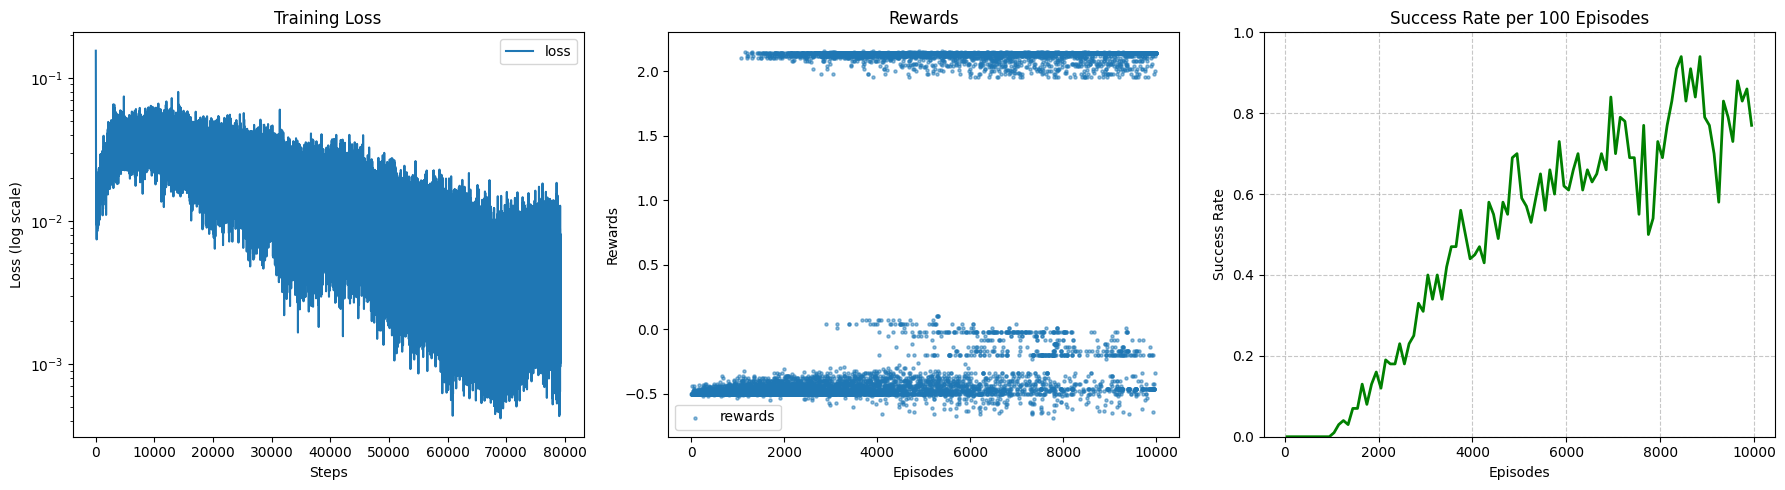

In [17]:
import matplotlib.pyplot as plt
import numpy as np 

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training Loss
xb = np.arange(0, len(losslog), 1)
ax1.set_yscale("log")
ax1.plot(xb, losslog, label="loss")
ax1.set_title("Training Loss")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Loss (log scale)")
ax1.legend()

# Plot 2: Rewards Scatter
ep = np.arange(0, len(rewards_log), 1)
ax2.scatter(ep, rewards_log, label="rewards", alpha=0.5, s=5)
ax2.set_title("Rewards")
ax2.set_xlabel("Episodes")
ax2.set_ylabel("Rewards")
ax2.legend()

# Plot 3: Success Rate over time (every 100 episodes)
# Reward > 1.5 can only be achieved when success
bins = 100
num_bins = len(rewards_log) // bins
success_rates = []
episodes = []

for i in range(num_bins):
    start_idx = i * bins
    end_idx = min((i + 1) * bins, len(rewards_log))
    bin_rewards = rewards_log[start_idx:end_idx]
    success_rate = sum(reward > 1.5 for reward in bin_rewards) / len(bin_rewards)
    success_rates.append(success_rate)
    episodes.append(i * bins + bins/2) 

ax3.plot(episodes, success_rates, 'g-', linewidth=2)
ax3.set_title("Success Rate per 100 Episodes")
ax3.set_xlabel("Episodes")
ax3.set_ylabel("Success Rate")
ax3.set_ylim([0, 1])
ax3.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()